In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# Credit card fraud detection

In [2]:
df = pd.read_csv('data/creditcard.csv')

## Data exploration

Firsly, we need to look at the data and see wether any fraudulent activity is correlated to any of the features. Also, wether the data is balanced in their class, amount.

In [38]:
print(f"Number of not fraudulent transactions: {df[df['Class']==0]['Class'].count()}\n",
      f"Number of fraudulent transactions: {df[df['Class']==1]['Class'].count()}\n",
      f"Minimum transaction amount: {np.min(df['Amount'])}", 
            f", number of transations: {df[df['Amount']==np.min(df['Amount'])]['Class'].count()}\n",
      f"Maximum transaction amount: {np.max(df['Amount'])}", 
            f", number of transations: {df[df['Amount']==np.max(df['Amount'])]['Class'].count()}", 
            f", class: {df[df['Amount']==np.max(df['Amount'])]['Class'].iloc[0]}\n",
      f"Mean transaction amount: {np.mean(df['Amount'])}\n",
      f"Median transaction amount: {np.median(df['Amount'])}")

Number of not fraudulent transactions: 284315
 Number of fraudulent transactions: 492
 Minimum transaction amount: 0.0 , number of transations: 1825
 Maximum transaction amount: 25691.16 , number of transations: 1 , class: 0
 Mean transaction amount: 88.34961925093133
 Median transaction amount: 22.0


Text(0.5, 1.0, 'Transaction amount distribution')

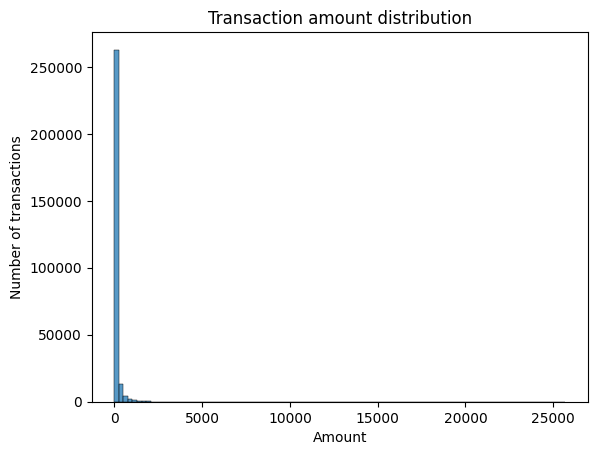

In [19]:
sns.histplot(df['Amount'], bins=100)
plt.xlabel('Amount')
plt.ylabel('Number of transactions')
plt.title('Transaction amount distribution')

We can see that the transaction amount is mostly centered around 0, with a long tale. From the maximum value, we know that the maximum transation is not a fraudulent one. Now we want to see witch features correlate with class.

### Correlation

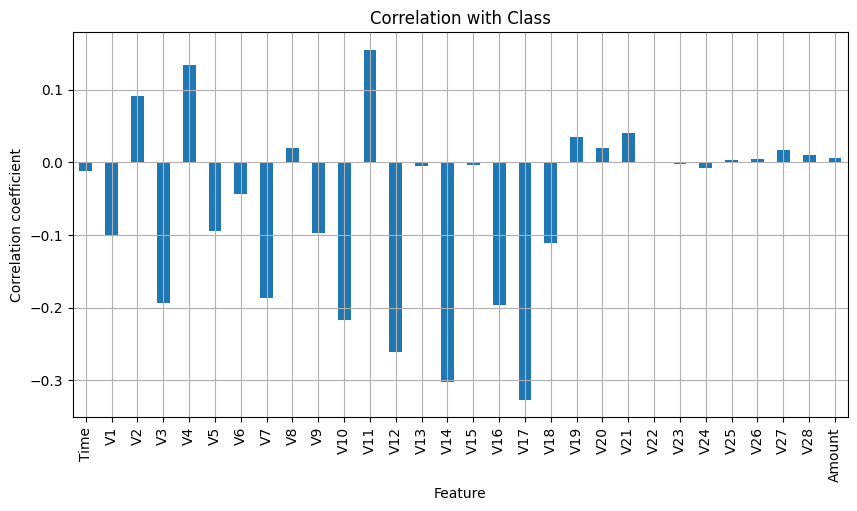

In [21]:
correlation = df.corr()['Class'][0:30]
correlation.plot(kind='bar', figsize=(10,5), title='Correlation with Class', grid=True)
plt.xlabel('Feature')
plt.ylabel('Correlation coefficient')
plt.show()

We see that a few features correlate with the class, while features like, Time, V9, V13, V14, V22 to V28, and amount, do not show strong correlation.

Since we will want to throw out features that are not correlated with Class and that are strongly correlated with each other (i.e. if two features are strongly correlated only keep one), we need to also see the correalation heatmap.

<Axes: >

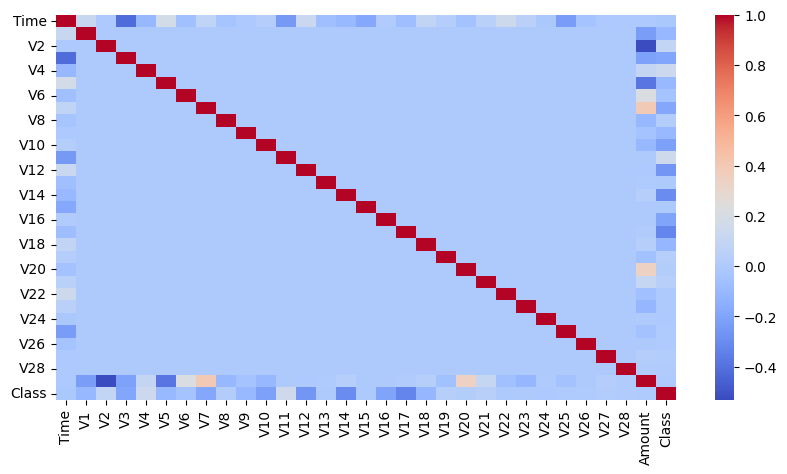

In [33]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False, fmt=".2f")

Amount and class do not correlate, however, Amount and all other variables do correlate. To only keep features that correlate with class, we'll drop anything that has correlation with Class below 0.1, which will also drop Time and Amount from feature table, since it is not correlated with class.

In [22]:
correlated = df.corr()['Class']
df2 = df.copy()
for i in df.columns:
    if abs(correlated[i]) < 0.10:
        df2.drop(columns=[i], inplace=True)

We keep only the features that correlate to Class, and check if they correlate with each other again.

<Axes: >

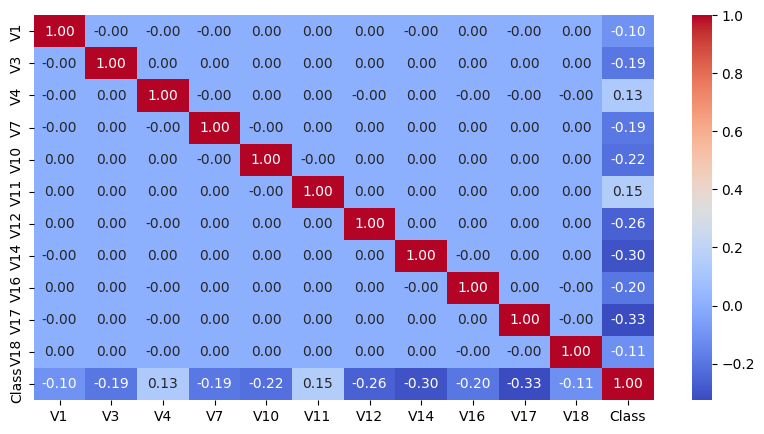

In [31]:
plt.figure(figsize=(10,5))
sns.heatmap(df2.corr(), cmap='coolwarm', annot=True, fmt=".2f")

Since none of the features correlate with each other we will continue to work with this table. If they were we would need to throw out any features that show correlation factor of more than abs(0.8) since it would indicate strong correlation

## Model selection

Data is unbalanced (much more non fraudulent transactions, than fraudulent ones). Therefore, resampling technique needs to be used. Oversampling, where the minority class is artificially increased, might lead to overfitting a model, while undersampling, where the samples from majority class are removed, might result in loss of information. 

Since the amount of fraudulent samples is much smaller than non fraudulent ones, we are choosing not to increase the fraudulent sample number, but to decrease the non fraudulent in hopes not to loose too much information.

In [5]:
from imblearn.under_sampling import RandomUnderSampler

X = df2.drop(columns=['Class'])
y = df2['Class']

rus = RandomUnderSampler(random_state=42)

X_res, y_res = rus.fit_resample(X, y)

downsampled = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.DataFrame(y_res, columns=['Class'])], axis=1)
downsampled.shape

(984, 12)

From previous experience we know that the ensemble models are one of the most accurate. We choose voting regressor since it takes the predictions of all provided models and outputs their average result.


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95        99
           1       0.97      0.92      0.94        98

    accuracy                           0.94       197
   macro avg       0.95      0.94      0.94       197
weighted avg       0.95      0.94      0.94       197



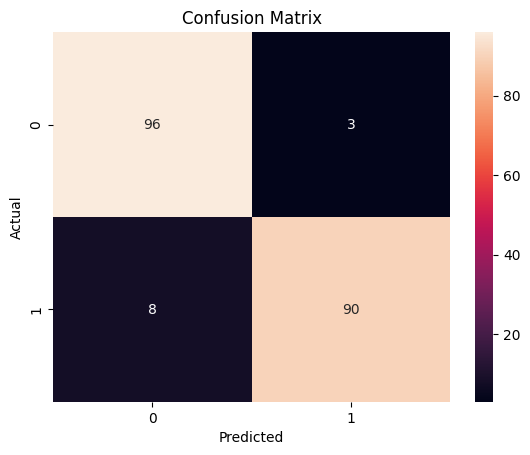

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.semi_supervised import LabelSpreading, LabelPropagation

x = downsampled.drop(columns=['Class'])
y = downsampled['Class']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = GaussianNB()
clf3 = HistGradientBoostingClassifier(random_state=42)
clf4 = LabelSpreading()
clf5 = LabelPropagation()

ensemble = VotingClassifier(estimators=[('rf', clf1), ('gnb', clf2), ('gbc', clf3), ('label_spreading', clf4), ('label_propagation', clf5)], voting='hard')
ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)


In credit card fraud detection having false negatives is quite dangerous, in this case 8 FN are returned therefore we need to see if we can lower this number and catch more fraudulent activities. Therefore we could adjust the classification thresholds to catch more false negative values, however, it might increase our false positives. Considering our goal to catch as much fraudulent activity as possible, blocking a few more non-fraudulent payments would be less damaging.

Confusion Matrix:
[[95  4]
 [ 4 94]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        99
           1       0.96      0.96      0.96        98

    accuracy                           0.96       197
   macro avg       0.96      0.96      0.96       197
weighted avg       0.96      0.96      0.96       197



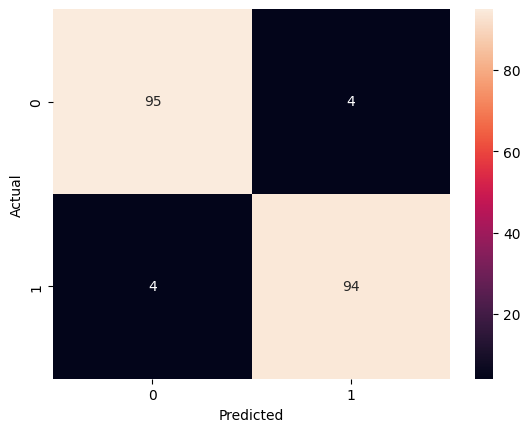

In [25]:
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = GaussianNB()
clf3 = HistGradientBoostingClassifier(random_state=42)
clf4 = LabelSpreading()
clf5 = LabelPropagation()

fradulent_catched = VotingClassifier(estimators=[('rf', clf1), ('gnb', clf2), ('gbc', clf3), ('label_spreading', clf4),  ('label_propagation', clf5)], voting='soft')

fradulent_catched.fit(X_train, y_train)

y_probability = fradulent_catched.predict_proba(X_test)[:,1]


threshold = 0.3
y_pred = (y_probability >= threshold).astype(int)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

The above model decreased the FN value to 4, while not majorly increasing the False Positives, and achieving accuracy score of 0.96.